Imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading dataset

In [25]:
co2_dataset = pd.read_csv('CO2_emission.csv')
co2_dataset.head()

,Country Name,country_code,Region,Indicator Name,1990,1991,1992,1993,1994,1995,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019.1
0,Aruba,ABW,Latin America & Caribbean,CO2 emissions (metric tons per capita),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,South Asia,CO2 emissions (metric tons per capita),0.191745,0.167682,0.095958,0.084721,0.075546,0.068468,...,0.296506,0.259295,0.185624,0.146236,0.172897,0.149789,0.131695,0.163295,0.159824,0.159824
2,Angola,AGO,Sub-Saharan Africa,CO2 emissions (metric tons per capita),0.553662,0.544539,0.543557,0.708984,0.836804,0.912141,...,0.985522,0.950696,1.036294,1.099779,1.135044,1.031811,0.813301,0.777675,0.792137,0.792137
3,Albania,ALB,Europe & Central Asia,CO2 emissions (metric tons per capita),1.819542,1.242810,0.683700,0.638307,0.645355,0.605436,...,1.669423,1.503240,1.533630,1.668337,1.603775,1.557664,1.788786,1.782739,1.692248,1.692248
4,Andorra,AND,Europe & Central Asia,CO2 emissions (metric tons per capita),7.521832,7.235379,6.963079,6.724178,6.541579,6.733479,...,5.850886,5.944654,5.942800,5.807128,6.026182,6.080600,6.104134,6.362975,6.481217,6.481217


Exploring dataset and dealing with missing values

In [26]:
co2_dataset.dropna(axis=0, inplace=True)
co2_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 214
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    183 non-null    object 
 1   country_code    183 non-null    object 
 2   Region          183 non-null    object 
 3   Indicator Name  183 non-null    object 
 4   1990            183 non-null    float64
 5   1991            183 non-null    float64
 6   1992            183 non-null    float64
 7   1993            183 non-null    float64
 8   1994            183 non-null    float64
 9   1995            183 non-null    float64
 10  1996            183 non-null    float64
 11  1997            183 non-null    float64
 12  1998            183 non-null    float64
 13  1999            183 non-null    float64
 14  2000            183 non-null    float64
 15  2001            183 non-null    float64
 16  2002            183 non-null    float64
 17  2003            183 non-null    flo

In [27]:
co2_dataset['Region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Middle East & North Africa', 'Latin America & Caribbean',
       'East Asia & Pacific', 'North America'], dtype=object)

Plotting basic graphs grouped by region

In [28]:
g = co2_dataset.groupby(by='Region').sum()

In [29]:
g.index

Index(['East Asia & Pacific', 'Europe & Central Asia',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'North America', 'South Asia', 'Sub-Saharan Africa'],
      dtype='object', name='Region')

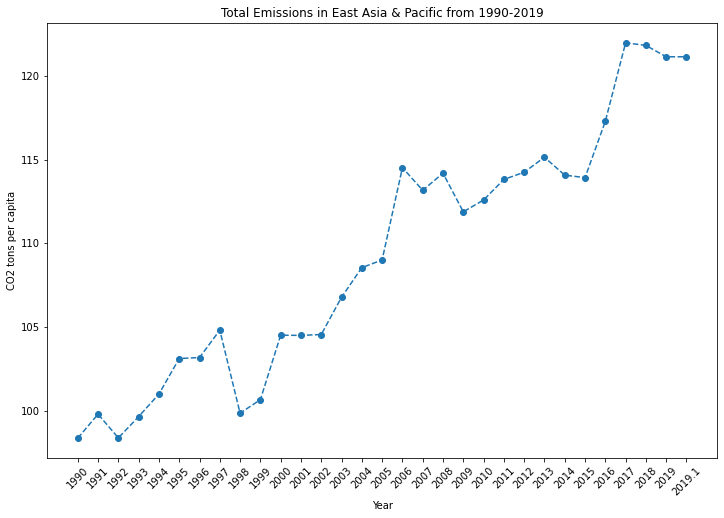

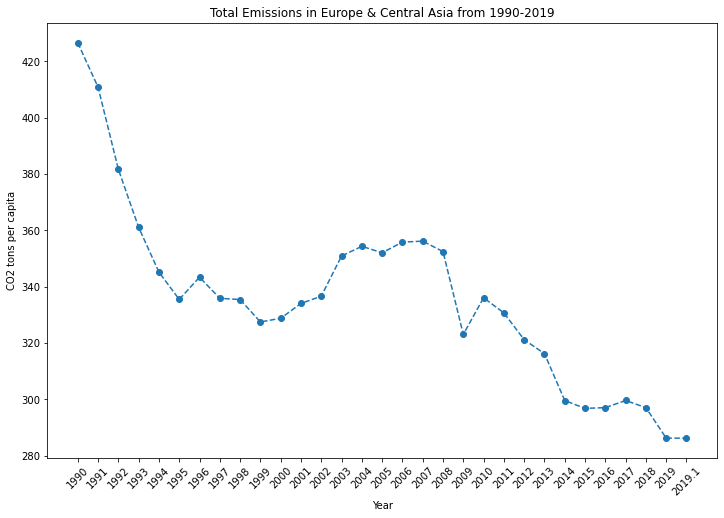

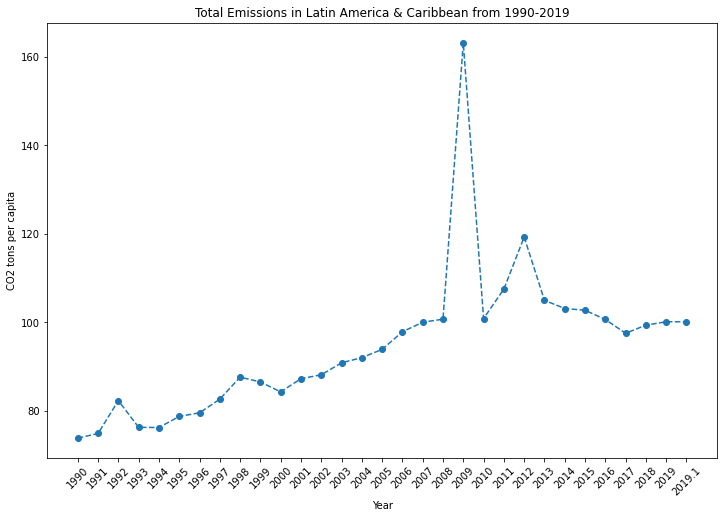

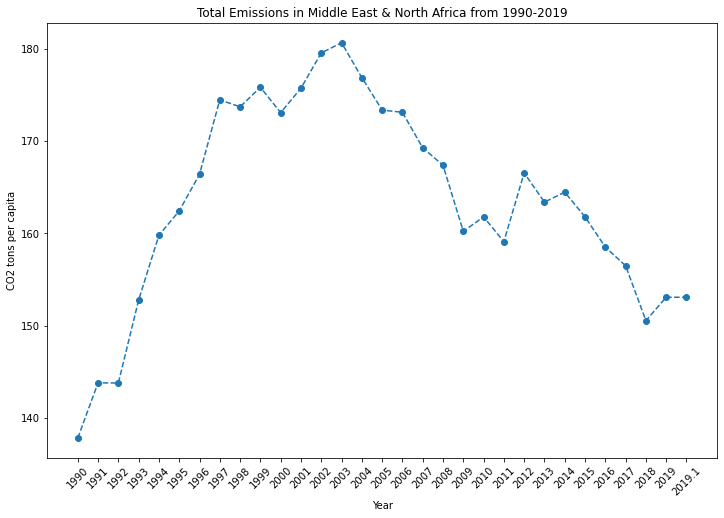

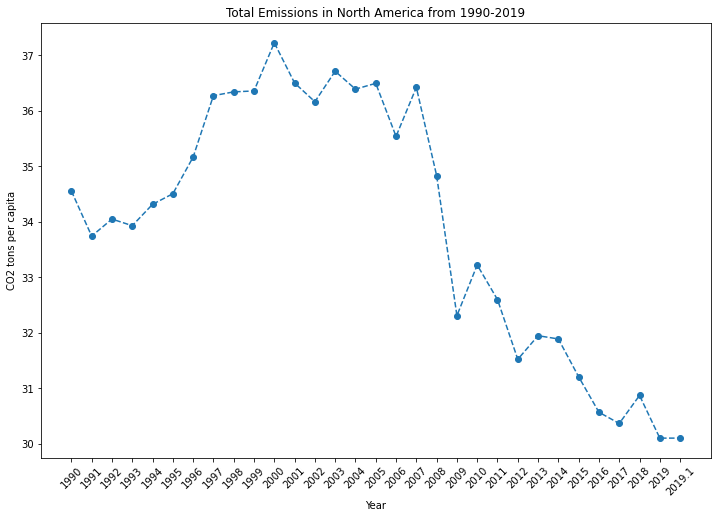

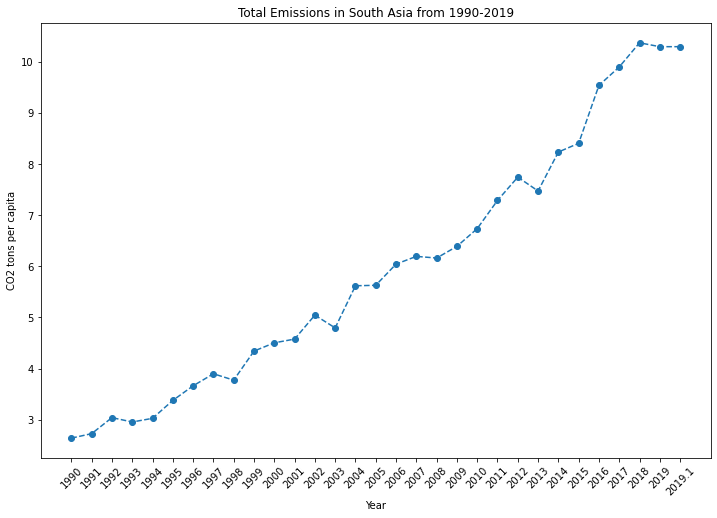

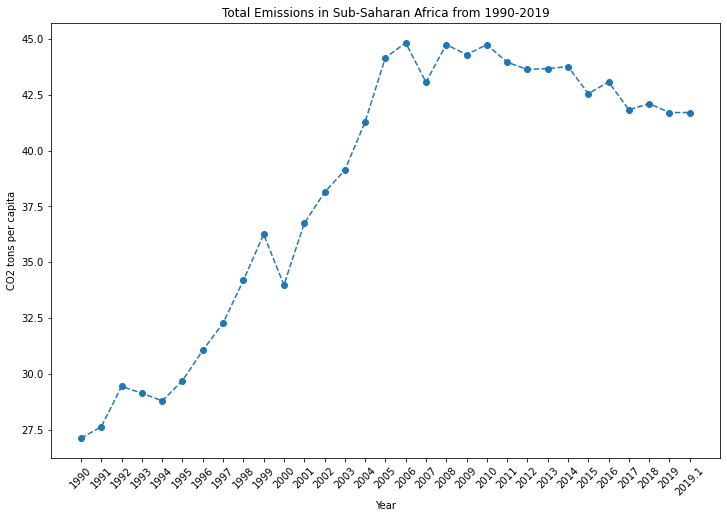

In [30]:
def plot_trends(data, feat):
    plt.figure(figsize=(12,8))
    plt.plot(data.loc[feat], '--o')
    plt.xlabel('Year')
    plt.ylabel('CO2 tons per capita')
    plt.xticks(rotation=45) 
    plt.title('Total Emissions in ' + feat + ' from 1990-2019')

[plot_trends(co2_dataset.groupby(by='Region').sum(), i) for i in g.index];
plt.show()

Creating new grouped data frame and basic plot

In [31]:
new_dataset = co2_dataset.groupby(by='Region').sum()
legends = new_dataset.index

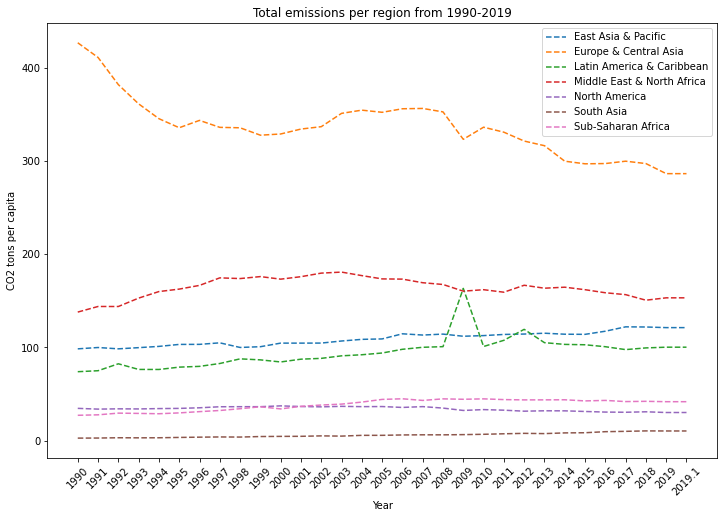

In [32]:
plt.figure(figsize=(12,8))
plt.plot(new_dataset.T, '--', label=legends)
plt.xlabel('Year')
plt.ylabel('CO2 tons per capita')
plt.xticks(rotation=45) 
plt.legend()
plt.title('Total emissions per region from 1990-2019')
plt.show()


In [33]:
new_dataset.reset_index(inplace=True)
df = new_dataset.rename(columns = {'index':'Region'})

In [34]:
new_dataset

,Region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2019.1
0,East Asia & Pacific,98.373009,99.802271,98.386979,99.655951,101.003446,103.124329,103.182183,104.815299,99.862843,...,113.811910,114.239996,115.135462,114.067628,113.918365,117.279083,121.966613,121.807264,121.131826,121.131826
1,Europe & Central Asia,426.580142,410.837272,381.689259,361.074328,345.182576,335.477591,343.361999,335.886209,335.422792,...,330.701016,321.189953,316.231169,299.593460,296.797127,297.071287,299.601600,297.051216,286.244383,286.244383
2,Latin America & Caribbean,73.863953,74.914989,82.343662,76.298756,76.258303,78.760998,79.581012,82.659459,87.639062,...,107.527254,119.294947,104.991859,103.144721,102.749714,100.662825,97.555050,99.377463,100.148730,100.148730
3,Middle East & North Africa,137.802569,143.802469,143.778778,152.773977,159.803849,162.442157,166.411935,174.492070,173.730181,...,159.110188,166.565667,163.399399,164.477529,161.797789,158.516955,156.496772,150.538558,153.082133,153.082133
4,North America,34.556236,33.744417,34.051095,33.931719,34.316557,34.507511,35.167971,36.274841,36.342812,...,32.600162,31.524257,31.949645,31.890826,31.208621,30.570487,30.367832,30.873127,30.104023,30.104023
5,South Asia,2.636176,2.723893,3.037818,2.952127,3.023854,3.375510,3.661086,3.896621,3.772312,...,7.292716,7.749087,7.477978,8.241143,8.411531,9.547236,9.907264,10.381212,10.304685,10.304685
6,Sub-Saharan Africa,27.117814,27.625659,29.435103,29.132057,28.787870,29.691015,31.046645,32.271409,34.178591,...,43.955300,43.631622,43.671660,43.759554,42.547119,43.073010,41.824696,42.100814,41.702448,41.702448


In [35]:
# Creating data frame with dates
new_dates_df = new_dataset.T.reset_index()
new_dates_df.columns = new_dates_df.iloc[0]
new_dates_df = new_dates_df.iloc[1:-1]
new_dates_df.rename(columns={'Region':'Year'}, inplace=True)
# Converting columns data types
new_dates_df['Year'] = pd.to_datetime(new_dates_df['Year'])
cols = ['East Asia & Pacific', 'Europe & Central Asia',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'North America', 'South Asia', 'Sub-Saharan Africa']
new_dates_df[cols] = new_dates_df[cols].apply(pd.to_numeric, errors='coerce')
new_dates_df['Total Emissions'] = new_dates_df[cols].sum(axis=1)
new_dates_df

,Year,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa,Total Emissions
1,1990-01-01,98.373009,426.580142,73.863953,137.802569,34.556236,2.636176,27.117814,800.929899
2,1991-01-01,99.802271,410.837272,74.914989,143.802469,33.744417,2.723893,27.625659,793.450971
3,1992-01-01,98.386979,381.689259,82.343662,143.778778,34.051095,3.037818,29.435103,772.722694
4,1993-01-01,99.655951,361.074328,76.298756,152.773977,33.931719,2.952127,29.132057,755.818915
5,1994-01-01,101.003446,345.182576,76.258303,159.803849,34.316557,3.023854,28.787870,748.376454
6,1995-01-01,103.124329,335.477591,78.760998,162.442157,34.507511,3.375510,29.691015,747.379110
7,1996-01-01,103.182183,343.361999,79.581012,166.411935,35.167971,3.661086,31.046645,762.412831
8,1997-01-01,104.815299,335.886209,82.659459,174.492070,36.274841,3.896621,32.271409,770.295908
9,1998-01-01,99.862843,335.422792,87.639062,173.730181,36.342812,3.772312,34.178591,770.948594
10,1999-01-01,100.667709,327.488471,86.554619,175.855354,36.359655,4.341482,36.247834,767.515125


Saving data frames to csv files

In [36]:
# Data frames with regions grouped
new_dataset.to_csv('co2_emissions_region.csv', index=False)
new_dates_df.to_csv('co2_emissions_dates_region.csv', index=False)

Creating new data frames with grouping by countries

In [37]:
new_dataframe2 = co2_dataset.drop(columns=['country_code', 'Indicator Name', 'Region'])

In [38]:
# Creating data frame with
new_dates_df2 = new_dataframe2.T.reset_index()
new_dates_df2.columns = new_dates_df2.iloc[0]
new_dates_df2 = new_dates_df2.iloc[1:-1]
new_dates_df2.rename(columns={'Country Name':'Year'}, inplace=True)
# Converting columns data types
new_dates_df2['Year'] = pd.to_datetime(new_dates_df['Year'])
cols = list(new_dates_df2.columns)
cols.remove('Year')
new_dates_df2[cols] = new_dates_df2[cols].apply(pd.to_numeric, errors='coerce')
new_dates_df2['Total Emissions'] = new_dates_df2[cols].sum(axis=1)
new_dates_df2

,Year,Afghanistan,Angola,Albania,Andorra,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,...,St. Vincent and the Grenadines,"Venezuela, RB",Vietnam,Vanuatu,Samoa,"Yemen, Rep.",South Africa,Zambia,Zimbabwe,Total Emissions
1,1990-01-01,0.191745,0.553662,1.819542,7.521832,30.195189,3.075541,5.610254,3.358227,15.448488,...,0.744262,5.176577,0.284311,0.477571,0.552836,0.567037,6.729799,0.340930,1.585444,800.929899
2,1991-01-01,0.167682,0.544539,1.242810,7.235379,31.778496,3.202031,5.902576,3.472058,15.318213,...,0.835096,5.025300,0.285151,0.464444,0.609756,0.690937,6.424622,0.349232,1.713321,793.450971
3,1992-01-01,0.095958,0.543557,0.683700,6.963079,29.080926,3.218974,3.166009,4.498984,15.341526,...,1.111718,5.015640,0.293580,0.386658,0.604266,0.704793,6.175430,0.337224,1.694416,772.722694
4,1993-01-01,0.084721,0.708984,0.638307,6.724178,29.275678,3.245795,1.498612,3.800721,15.455369,...,1.203303,5.109697,0.335268,0.375603,0.658221,0.627105,6.219194,0.289956,1.539741,755.818915
5,1994-01-01,0.075546,0.836804,0.645355,6.541579,30.849333,3.252945,0.834434,3.720183,15.691963,...,1.295589,4.960755,0.362248,0.365568,0.592807,0.653256,6.215847,0.241270,1.417186,748.376454
6,1995-01-01,0.068468,0.912141,0.605436,6.733479,31.125018,3.241342,1.090960,3.931733,16.056884,...,1.388336,5.199925,0.419167,0.416268,0.705675,0.706081,6.378790,0.234153,1.356619,747.379110
7,1996-01-01,0.062588,1.072168,0.612367,6.991595,30.928026,3.476953,0.814339,3.989968,16.427830,...,1.389108,5.442772,0.460505,0.524106,0.759501,0.698158,6.489192,0.188442,1.287559,762.412831
8,1997-01-01,0.056827,1.086637,0.466921,7.307441,30.486333,3.536990,1.066043,4.044236,16.625263,...,1.482923,5.586804,0.529474,0.514530,0.755528,0.728608,6.723589,0.238601,1.186793,770.295908
9,1998-01-01,0.052691,1.091825,0.572154,7.639539,29.663581,3.678794,1.116225,4.370450,17.562931,...,1.762409,5.552081,0.582085,0.449471,0.867860,0.757433,6.787424,0.219937,1.197745,770.948594
10,1999-01-01,0.040157,1.109860,0.955359,7.923192,28.887108,3.688518,1.006792,4.419209,17.632358,...,1.763128,5.284788,0.587202,0.496527,0.864025,0.830912,6.279186,0.173560,1.338101,767.515125


In [39]:
new_dates_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Columns: 185 entries, Year to Total Emissions
dtypes: datetime64[ns](1), float64(184)
memory usage: 43.5 KB


Saving data frames to csv files

In [40]:
# Dataset with countries grouped
new_dataframe2.to_csv('co2_emissions_countries.csv', index=False)
new_dates_df2.to_csv('co2_emissions_dates_countries.csv', index=False)

Creating data frames with regions and countries and exploring values

In [41]:
new_dataframe3 = co2_dataset.drop(columns=['country_code', 'Indicator Name'])
new_dataframe3['Total Emissions'] = new_dataframe3[list(new_dataframe3.columns)].sum(axis=1) # Drop any non-numeric columns
# Dataset with countries and regions
new_dataframe3.to_csv('co2_emissions_all.csv', index=False)

C:\Users\pablo\AppData\Local\Temp/ipykernel_32828/863938901.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  new_dataframe3['Total Emissions'] = new_dataframe3[list(new_dataframe3.columns)].sum(axis=1) # Drop any non-numeric columns


In [42]:
print(new_dataframe3['Total Emissions'].max())
print(new_dataframe3['Total Emissions'].min())

1183.47966451
1.1106481149999998


In [43]:
new_dataframe3['Total Emissions'].median()

74.25065940400002

Adding total emissions column

In [44]:
emissions_year = pd.DataFrame(new_dataframe3.sum(axis=0))
emissions_year = emissions_year.iloc[2:-2]
emissions_year.columns = ['Total Emissions']

In [45]:
emissions_year.reset_index(inplace=True)
emissions_year.rename(columns = {'index':'Year'}, inplace=True)

Plotting world's total emissions per year

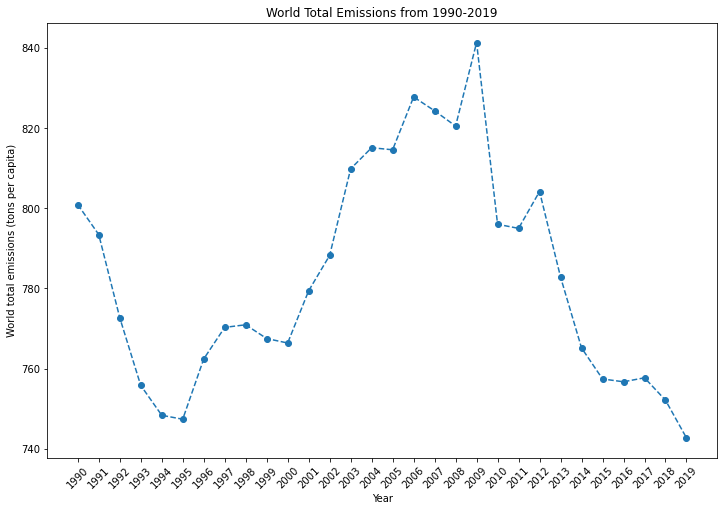

In [46]:
plt.figure(figsize=(12,8))
plt.plot(emissions_year['Year'], emissions_year['Total Emissions'], '--o')
plt.xlabel('Year')
plt.ylabel('World total emissions (tons per capita)')
plt.xticks(rotation=45) 
plt.title('World Total Emissions from 1990-2019')
plt.show()

#### Insights

There are only three countries above 671 tons emitted 1990 to 2019: Bahrain, Qatar and UAE. 
- Include more insights on the data